In [2]:
%matplotlib_svg
import numpy as np
import pylab as pl
import cv2
from cv2 import cv

## 图像识别

### 用Hough变换检测直线和圆

> **SOURCE**

> `scpy2.opencv.hough_demo`：霍夫变换演示程序，可通过界面调节函数的所有参数。

#### 检测线段

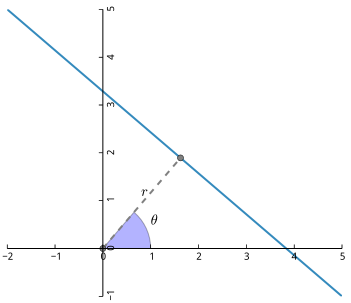

In [190]:
#%figonly=用r和θ表示的直线
from scpy2.matplotlib import make_zerocross_axes
   
ax = make_zerocross_axes(figsize=(6, 6), loc=111)
    
x = [-2, 5]
y = [5, -1]
ax.plot(x, y)

from sympy import Point, Line
from sympy import Point, Line
line = Line(Point(x[0], y[0]), Point(x[1], y[1]))
seg = line.perpendicular_segment(Point(0, 0))

ax.plot([seg.p1.x, seg.p2.x], [seg.p1.y, seg.p2.y], "--o", color="gray")
from matplotlib.patches import Wedge
angle = np.rad2deg(np.arctan2(float(seg.p2.y), float(seg.p2.x)))
theta = Wedge((0, 0), 1, 0, angle, alpha=0.3)
ax.add_patch(theta)
ax.text(1, 0.5, r"$\theta$", fontsize="large")
ax.text(0.8, 1.1, r"$r$", fontsize="large");

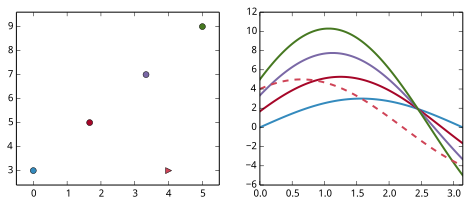

In [204]:
#%figonly=霍夫变换示意图
k = 1.2
b = 3

xn, yn = 4, 3

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(8, 3))
xs = np.linspace(0, 5, 4)
ys = xs * k + b

for x0, y0 in zip(xs, ys):
    ax1.plot(x0, y0, "o")

ax1.plot(xn, yn, ">")
ax1.margins(0.1, 0.1)

theta = np.linspace(0, np.pi, 100)
for x0, y0 in zip(xs, ys):
    r = x0 * np.cos(theta) + y0 * np.sin(theta)
    ax2.plot(theta, r)

r = xn * np.cos(theta) + yn * np.sin(theta)
ax2.plot(theta, r, "--")
ax2.set_xlim(0, np.max(theta));

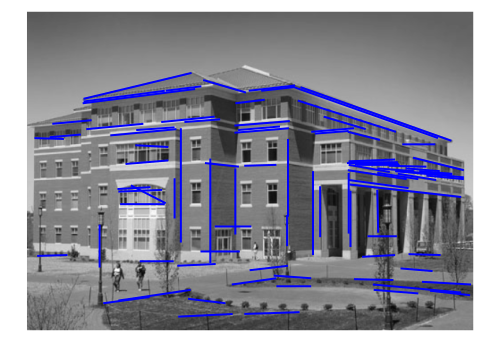

In [217]:
#%fig=使用HoughLinesP()检测图像中的直线
img = cv2.imread("building.jpg", cv2.IMREAD_GRAYSCALE)
img_binary = cv2.Canny(img, 100, 255)
lines = cv2.HoughLinesP(img_binary, rho=1, theta=np.deg2rad(0.1),
                        threshold=96, minLineLength=33,
                        maxLineGap=4)

fig, ax = pl.subplots(figsize=(8, 6))
pl.imshow(img, cmap="gray")
from matplotlib.collections import LineCollection
lc = LineCollection(lines.reshape(-1, 2, 2))
ax.add_collection(lc)
ax.axis("off");

#### 检测圆形

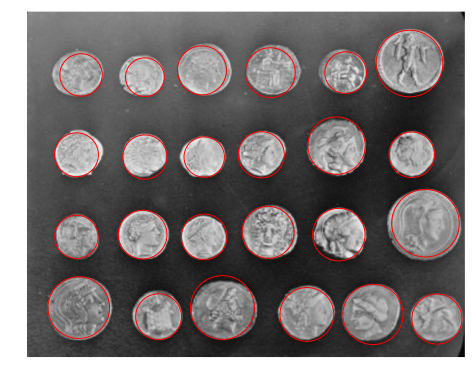

In [3]:
#%fig=使用HoughCircles()检测图像中的圆形
img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
img_blur = cv2.GaussianBlur(img, (0, 0), 1.8) #❶
circles = cv2.HoughCircles(img_blur, cv.CV_HOUGH_GRADIENT, dp=2.0, minDist=20.0,
                 param1=170, param2=44, minRadius=16, maxRadius=40)

x, y, r = circles[0].T

fig, ax = pl.subplots(figsize=(8, 6))
pl.imshow(img, cmap="gray")
from matplotlib.collections import EllipseCollection
ec = EllipseCollection(widths=2*r, heights=2*r, angles=0, units="xy", # ❷
                       facecolors="none", edgecolors="red",
                       transOffset=ax.transData, offsets=np.c_[x, y])
ax.add_collection(ec)
ax.axis("off");

### 图像分割

#### Mean-Shift法

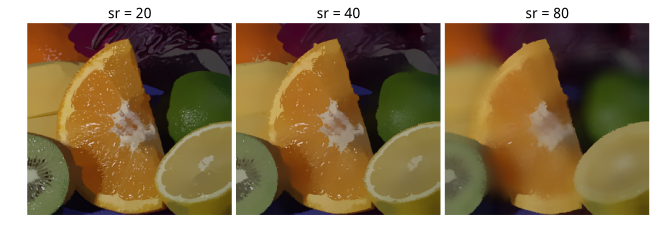

In [5]:
#%fig=使用pyrMeanShiftFiltering()进行图像分割，从左到右参数sr分别为20, 40, 80
fig, axes = pl.subplots(1, 3, figsize=(9, 3))

img = cv2.imread("fruits.jpg")

srs = [20, 40, 80]
for ax, sr in zip(axes, srs):
    img2 = cv2.pyrMeanShiftFiltering(img, sp=20, sr=sr, maxLevel=1)
    ax.imshow(img2[:,:,::-1])
    ax.set_axis_off()
    ax.set_title("sr = {}".format(sr))
    
fig.subplots_adjust(0.02, 0, 0.98, 1, 0.02, 0) 

#### 分水岭算法

In [28]:
img = cv2.imread("pills.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.blur(img_gray, (15, 15)) #❶
_, img_binary = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY) #❷
peaks = img_gray == cv2.dilate(img_gray, np.ones((7, 7)), 1) #❸
peaks &= img_binary
peaks[1, 1] = True  #❹

from scipy.ndimage import label
markers, count = label(peaks) #❺
cv2.watershed(img, markers)

> **SOURCE**

> `scpy2.opencv.watershed_demo`：分水岭算法的演示程序。用鼠标在图像上绘制初始区域，初始区域将使用“当前标签”填充，按鼠标右键切换到下一个标签。每次绘制初始区域之后，将显示分割的结果。

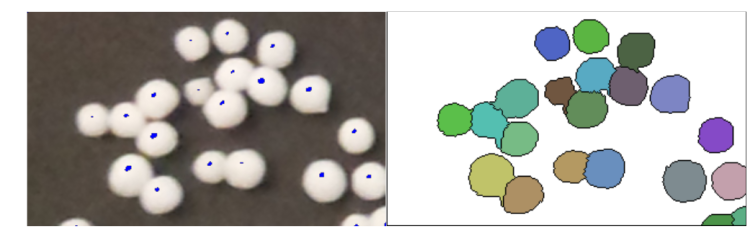

In [29]:
#%figonly=使用watershed分割药丸
fig, axes = pl.subplots(1, 2, figsize=(10, 3))
axes[0].imshow(img[:, :, ::-1])
peaks_img = np.zeros(img.shape[:2] + (4,), np.uint8)
peaks_img[peaks, 2] = 255
peaks_img[peaks, -1] = 255
axes[0].imshow(peaks_img)

colors = np.random.randint(64, 200, (count+2, 3)).astype(np.uint8)
colors[markers[1, 1]] = 255, 255, 255
colors[-1] = 0
axes[1].imshow(colors[markers])
for ax in axes:
    ax.axis("off")
fig.subplots_adjust(0, 0, 1, 1, 0, 0);

In [1]:
#%hide
%exec_python -m scpy2.opencv.watershed_demo

### SURF特征匹配

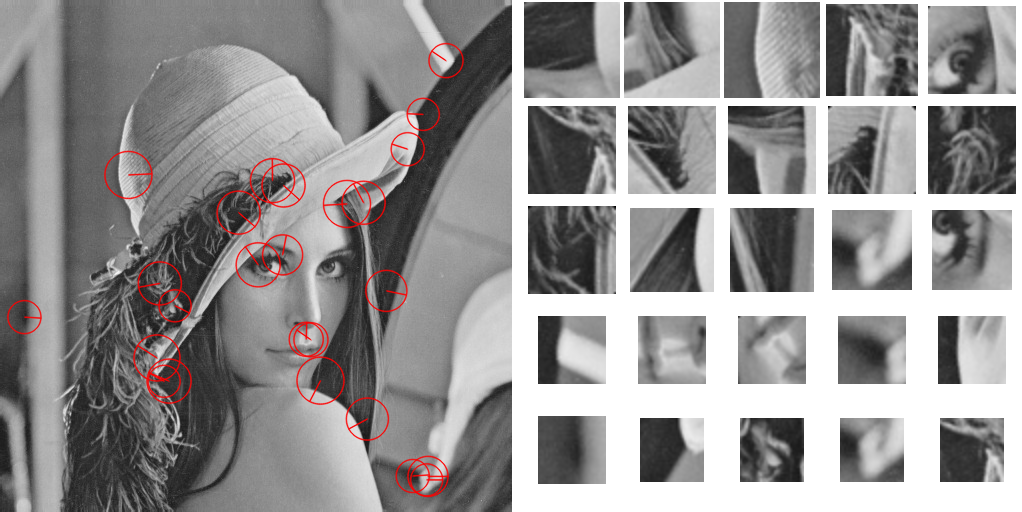

In [3]:
#%fig=SURF()找到的关键点和每个关键点的局部图像
img_gray1 = cv2.imread("lena.jpg", cv2.IMREAD_GRAYSCALE) #❶
surf = cv2.SURF(2000, 2)  #❷
key_points1 = surf.detect(img_gray1) #❸
key_points1.sort(key=lambda kp:kp.size, reverse=True) #❹

img_color1 = cv2.cvtColor(img_gray1, cv2.COLOR_GRAY2RGB)
cv2.drawKeypoints(img_color1, key_points1[:25], img_color1, color=(255, 0, 0),  #❺
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#%hide
from scpy2.utils.image import concat_keypoints
img_keypoints = concat_keypoints(img_gray1, key_points1[:25], 5, 5, scale=2)
%array_image img_color1; img_keypoints

In [4]:
_, features1 = surf.compute(img_gray1, key_points1)
features1.shape

(145, 128)

In [5]:
img_gray2 = cv2.imread("lena2.jpg", cv2.IMREAD_GRAYSCALE)
img_color2 = cv2.cvtColor(img_gray2, cv2.COLOR_GRAY2RGB)
surf2 = cv2.SURF(2000, 2)  
key_points2, features2 = surf2.detectAndCompute(img_gray2, None)

> **LINK**

> http://docs.opencv.org/modules/flann/doc/flann.html

> OpenCV关于FLANN的文档

In [6]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)   

fbm = cv2.FlannBasedMatcher(index_params, search_params) #❶
match_list = fbm.knnMatch(features1, features2, k=1) #❷

In [7]:
m = match_list[0][0]
%C m.distance; m.queryIdx; m.trainIdx

    m.distance     m.queryIdx  m.trainIdx
-----------------  ----------  ----------
0.414721816778183  0           21        


> **QUESTION**

> 请读者思考如何利用下面程序得到的`matrix`矩阵将变形之后的图像还原成原始图像。

In [13]:
key_positions1 = np.array([kp.pt for kp in key_points1])
key_positions2 = np.array([kp.pt for kp in key_points2])

index1 = np.array([m[0].queryIdx for m in match_list])
index2 = np.array([m[0].trainIdx for m in match_list])

distances = np.array([m[0].distance for m in match_list])

best_index = np.argsort(distances)[:50] #❶
matched_positions1 = key_positions1[index1[best_index]]
matched_positions2 = key_positions2[index2[best_index]]

matrix, mask = cv2.findHomography(matched_positions1, matched_positions2, cv2.RANSAC) #❷

> **SOURCE**

> `scpy2.opencv.surf_demo`：`SURF`图像匹配演示程序。用鼠标修改右侧图像的四个角的位置计算出透视变换之后的图像，然后在原始图像和变换之后的图像之间搜索匹配点，并计算透视变换的矩阵。

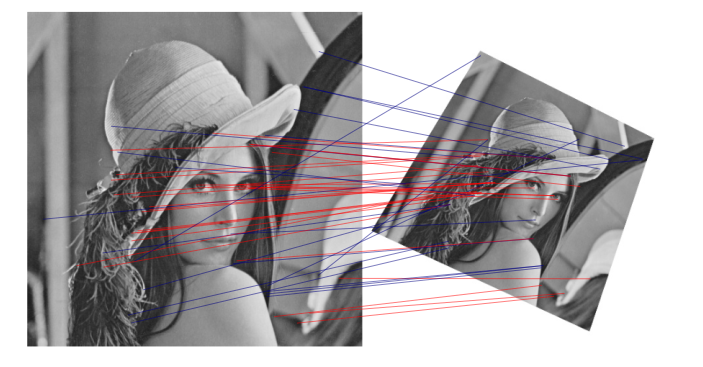

In [14]:
#%figonly=显示特征匹配的关键点
from matplotlib.collections import LineCollection
from scpy2.utils.image import concat_images

COLORS = np.array([[0, 0.0, 0.5], [1, 0, 0]])

img_color1 = cv2.cvtColor(img_gray1, cv2.COLOR_GRAY2RGB)
merged_img = concat_images([img_color1, img_color2], margin=0)

fig, ax = pl.subplots(figsize=(12, 6))
ax.axis("off")
pl.imshow(merged_img)
lines = np.concatenate([matched_positions1, matched_positions2], axis=1)
lines[:, 2] += img_color2.shape[1]
line_collection = LineCollection(lines.reshape(-1, 2, 2), 
                                 colors=COLORS[mask.ravel()], lw=1, alpha=0.5)
ax.add_collection(line_collection);

In [1]:
#%hide
%exec_python -m scpy2.opencv.surf_demo